## Defined Function for Image Processing (Converting to RGB Image)

In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU configured successfully")
    except RuntimeError as e:
        print(e)

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(image):
    image = np.array(image, dtype=np.uint8)

    # Apply CLAHE (local contrast enhancement)
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Normalize to [0,1] range
    normalized = blurred.astype(np.float32) / 255.0

    if normalized.ndim == 2:  # shape is (224, 224)
        normalized = np.expand_dims(normalized, axis=-1)

    return normalized

## Data Loading Along with Real-time Processing

In [13]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

train_generator = train_datagen.flow_from_directory(
    "../dataset/train/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    color_mode='grayscale',
)

val_generator = valid_datagen.flow_from_directory(
    "../dataset/valid/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    color_mode='grayscale',
)

test_generator = test_datagen.flow_from_directory(
    "../dataset/test/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    color_mode='grayscale',
)

Found 27672 images belonging to 8 classes.
Found 5539 images belonging to 8 classes.
Found 3690 images belonging to 8 classes.


In [15]:
# Print the class index mapping from ImageDataGenerator
print(train_generator.class_indices)

{'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutrality': 4, 'sadness': 5, 'sleepy': 6, 'surprise': 7}


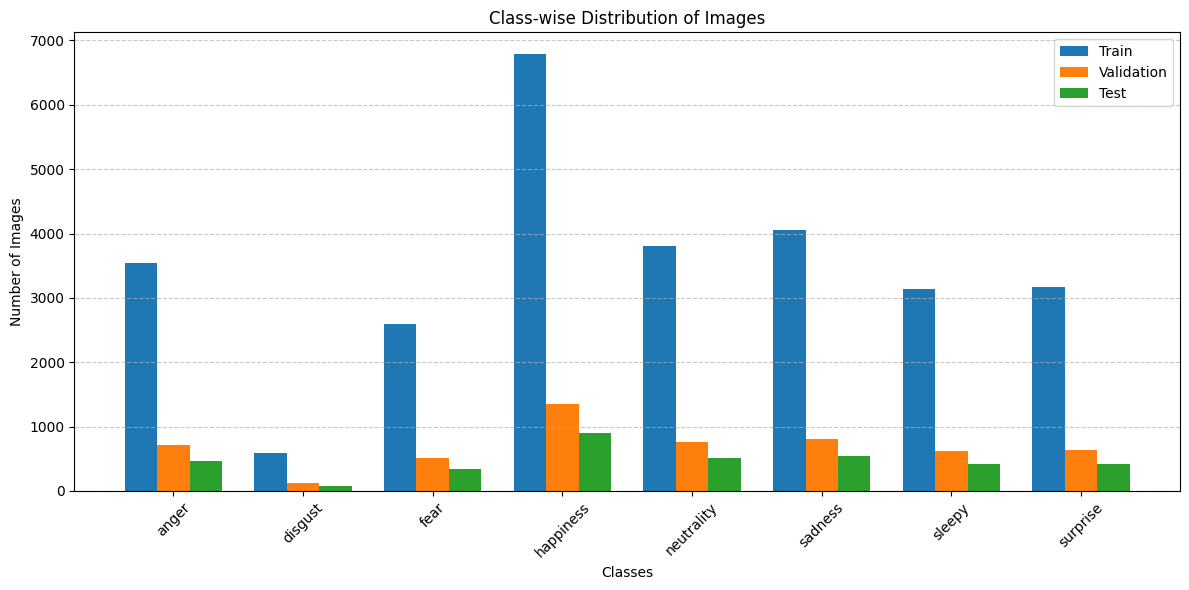

In [16]:
import matplotlib.pyplot as plt

# Access class names and sample counts
def get_class_distribution(generator):
    # Get count of images in each class using internal data
    class_counts = {class_name: 0 for class_name in generator.class_indices}
    for label in generator.labels:
        class_name = list(generator.class_indices.keys())[label]
        class_counts[class_name] += 1
    return class_counts

# Get distributions
train_dist = get_class_distribution(train_generator)
val_dist = get_class_distribution(val_generator)
test_dist = get_class_distribution(test_generator)

# Plot all three in one bar chart
labels = list(train_dist.keys())
x = range(len(labels))

plt.figure(figsize=(12, 6))

# Heights
train_heights = [train_dist[label] for label in labels]
val_heights = [val_dist[label] for label in labels]
test_heights = [test_dist[label] for label in labels]

bar_width = 0.25

# Create grouped bar chart
plt.bar([i - bar_width for i in x], train_heights, width=bar_width, label='Train')
plt.bar(x, val_heights, width=bar_width, label='Validation')
plt.bar([i + bar_width for i in x], test_heights, width=bar_width, label='Test')

# Styling
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class-wise Distribution of Images")
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


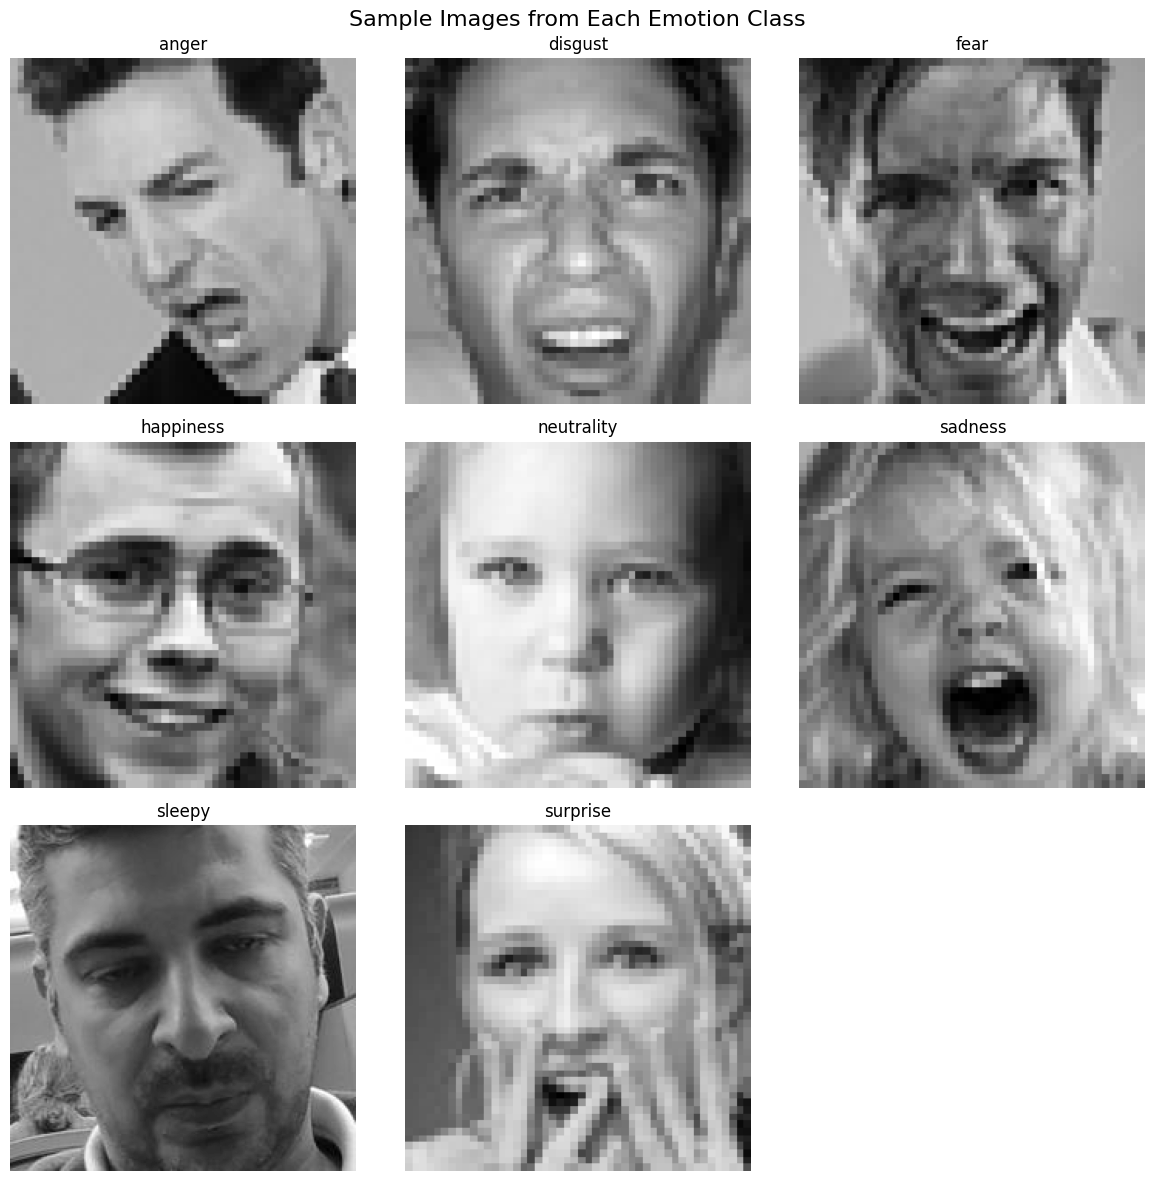

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Number of classes to show
n_classes = len(train_generator.class_indices)
cols = 3
rows = int(np.ceil(n_classes / cols))

plt.figure(figsize=(cols * 4, rows * 4))

for i, class_name in enumerate(train_generator.class_indices.keys()):
    folder_path = os.path.join("../dataset/train/", class_name)
    img_name = random.choice(os.listdir(folder_path))
    img_path = os.path.join(folder_path, img_name)
    
    img = load_img(img_path, color_mode="grayscale", target_size=(224, 224))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Sample Images from Each Emotion Class", fontsize=16)
plt.tight_layout()
plt.show()


## Self Defined Loss Function (Focal Loss)

In [18]:
class FocalLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=0.25, gamma=2.0, reduction=tf.keras.losses.Reduction.AUTO, name="focal_loss"):
    super().__init__(name=name,reduction=reduction)
    self.alpha = alpha
    self.gamma = gamma
    self.eps = 1e-7

  def focal_loss(self,target,output):
    """
    `FL(p_t) = alpha * (1 - p_t) ** gamma * CategoricalCE(y_true, y_pred)`
    """
    output = tf.clip_by_value(output, self.eps, 1.0 - self.eps)

    cce = -target * tf.math.log(output)

    modulating_factor = tf.pow(1.0 - output,self.gamma)
    weighting_factor = self.alpha * modulating_factor

    loss = weighting_factor * cce

    return tf.reduce_sum(loss, axis=-1)

  def call(self,y_true,y_pred):
    return self.focal_loss(y_true,y_pred)

In [26]:
# compute class weights used to handle imbalanced data.
import os
from sklearn.utils.class_weight import compute_class_weight

dataset_path = "../dataset/train/"

class_names = sorted(os.listdir(dataset_path))
print("Class Names:", class_names)

class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name)))
                for class_name in class_names}

class_indices = {class_name: i for i, class_name in enumerate(class_names)}

all_labels = []
for class_name, count in class_counts.items():
    all_labels.extend([class_indices[class_name]] * count)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}

Class Names: ['anger', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'sleepy', 'surprise']


In [27]:
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.9762912785774767, 1: 5.803691275167785, 2: 1.3355212355212356, 3: 0.5097259062776304, 4: 0.9093059936908517, 5: 0.8536525172754196, 6: 1.1044061302681993, 7: 1.091511517828968}


In [28]:
max_weight = 10
class_weight_dict = {k:np.clip(v,0.5,10) for k,v in class_weight_dict.items()}
class_weights = np.clip(class_weights,0.25,1)
class_weights

array([0.97629128, 1.        , 1.        , 0.50972591, 0.90930599,
       0.85365252, 1.        , 1.        ])

In [29]:
# Object for FocalLoss
focalLoss = FocalLoss(
    alpha = class_weights,
    reduction = 'sum_over_batch_size'
)

## Model Building

In [30]:
import keras
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2


model = Sequential([
    # 1st Conv Layer
    Input((224, 224, 1)),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    
    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.3),

    # 4th Conv Layer
    Conv2D(256, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # 5th Conv Layer
    Conv2D(512, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    GlobalAveragePooling2D(),

    # Hidden Layer
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    # Output Layer
    Dense(8, activation = 'softmax')
])

In [31]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=keras.losses.CategoricalFocalCrossentropy(), metrics=['accuracy'])

In [33]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-5
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    class_weight = class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/60
 15/865 [..............................] - ETA: 2:13:08 - loss: 1.0194 - accuracy: 0.1562

In [ ]:
# STEP-4 : Phase3 -> Testing Model
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
best_model.save('/content/modelv2.h5')